In [9]:
from keras.applications import DenseNet201

# MobileNet was designed to work on 224 x 224 pixel input images sizes
img_rows, img_cols = 224, 224 

# Re-loads the MobileNet model without the top or FC layers
DenseNet201 = DenseNet201(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in DenseNet201.layers:
    layer.trainable = False

In [10]:
def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

# Set our class number to 4
num_classes = 2

FC_Head = lw(DenseNet201, num_classes)

model = Model(inputs = DenseNet201.input, outputs = FC_Head)

print(model.summary())

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

In [12]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = 'dataset/train_face/'
validation_data_dir = 'dataset/val_face/'

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# set our batch size 
batch_size = 32
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 3833 images belonging to 2 classes.
Found 3833 images belonging to 2 classes.


In [13]:
from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping

                     
checkpoint = ModelCheckpoint("face_recognition.h5",
                             monitor="val_loss",
                             save_best_only = True,
                             verbose=1,
                             mode = 'auto',
                             save_freq = 'epoch')

earlystop = EarlyStopping(monitor = 'val_loss',
                          patience = 7,
                          verbose = 1,
                          mode = 'auto')

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]
# callbacks = [checkpoint]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

# Enter the number of training and validation samples here
nb_train_samples = 2000
nb_validation_samples = 400

epochs = 10
batch_size = 32

history = model.fit(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size
)

Epoch 1/10
62/62 [==============================] - ETA: 0s - loss: 0.2888 - accuracy: 0.8912
Epoch 00001: val_loss improved from inf to 0.01081, saving model to face_recognition.h5
62/62 [==============================] - 415s 7s/step - loss: 0.2888 - accuracy: 0.8912 - val_loss: 0.0108 - val_accuracy: 0.9948
Epoch 2/10
 7/62 [==>...........................] - ETA: 4:19 - loss: 0.0772 - accuracy: 0.9732

C:\Users\Asus\anaconda3\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


62/62 [==============================] - ETA: 0s - loss: 0.0565 - accuracy: 0.9793
Epoch 00002: val_loss improved from 0.01081 to 0.00850, saving model to face_recognition.h5
62/62 [==============================] - 376s 6s/step - loss: 0.0565 - accuracy: 0.9793 - val_loss: 0.0085 - val_accuracy: 0.9948
Epoch 3/10
62/62 [==============================] - ETA: 0s - loss: 0.0489 - accuracy: 0.9808
Epoch 00003: val_loss did not improve from 0.00850
62/62 [==============================] - 385s 6s/step - loss: 0.0489 - accuracy: 0.9808 - val_loss: 0.0154 - val_accuracy: 0.9948
Epoch 4/10
62/62 [==============================] - ETA: 0s - loss: 0.0693 - accuracy: 0.9747
Epoch 00004: val_loss did not improve from 0.00850
62/62 [==============================] - 393s 6s/step - loss: 0.0693 - accuracy: 0.9747 - val_loss: 0.0386 - val_accuracy: 0.9870
Epoch 5/10
62/62 [==============================] - ETA: 0s - loss: 0.0430 - accuracy: 0.9849
Epoch 00005: val_loss did not improve from 0.00850


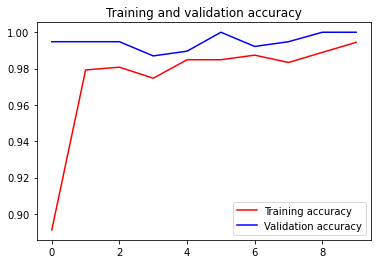

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

<Figure size 432x288 with 0 Axes>

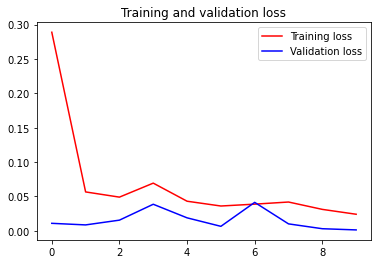

<Figure size 432x288 with 0 Axes>

In [15]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

In [16]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np


probas = model.predict_generator(generator=validation_generator)
y_true = validation_generator.classes
y_pred = np.argmax(probas, axis=1)

print(y_true.shape)
print(y_pred.shape)


print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

(3833,)
(3833,)
[[936 979]
 [985 933]]
              precision    recall  f1-score   support

           0       0.49      0.49      0.49      1915
           1       0.49      0.49      0.49      1918

    accuracy                           0.49      3833
   macro avg       0.49      0.49      0.49      3833
weighted avg       0.49      0.49      0.49      3833

